In [151]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [152]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import os
import numpy as np 
from numpy import abs as Abs
from numpy import sign as sign
from numpy import sqrt,pi,array

from control.matlab import *  # MATLAB-like functions
import control as ct
# from scipy import signal
from scipy.signal import cont2discrete, lti, dlti, dstep
 
import matplotlib
import matplotlib.pyplot as plt
 
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box
 
import random
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [153]:
n = 8
r = 3
M = np.load('M.npy')
C = np.load('C.npy')
K = np.load('K.npy')
# Ad = np.load('Ad.npy')
# Bd = np.load('Bd.npy')
# Ed = np.load('Ed.npy')
# Cd = np.load('Cd.npy')
# Dd = np.load('Dd.npy')


In [154]:
# GMdt = np.loadtxt('GMdt.txt', unpack = True)
# print(len(GMdt))
# a = np.random.randint(low=1,high=20)

# if a < 10:
#     f = "la"+"%02d" % a  + ".dat"
# else:
#     f = "la"+"%02d" % a  + ".dat"
# print(f)
# c = (np.array(np.loadtxt(f)).flatten())/100
# print(c)

# # Time series for ground motion
# dt = GMdt[a-1]
# print(dt)
# tend = dt*len(c)
# t = np.arange(0, tend, dt)
# plt.figure()
# plt.plot(t,c)

In [155]:
# State space representation
I = -1*np.ones([n,1])  # Influence vector
gamma = np.array([[ 1.,  0.,  0.],
                  [ 0.,  0.,  0.],
                  [ 0., -1.,  0.],
                  [ 0.,  1.,  0.],
                  [ 0.,  0., -1.],
                  [ 0.,  0.,  1.],
                  [ 0.,  0.,  0.],
                  [ 0.,  0.,  0.]])
A1 = np.zeros([n,n])
A2 = np.identity(n)
A3 = -1*np.linalg.inv(M) @ K
A4 = -1*np.linalg.inv(M) @ C
A = np.zeros([2*n,2*n])
A[0:n,n:2*n] = A2
A[n:2*n,0:n] = A3
A[n:2*n,n:2*n] = A4
# = np.ones((n,n), dtype=int)
# print(A)  
B = np.zeros((2*n,r))
B[n:2*n,0:r] = np.linalg.inv(M) @ gamma   # Input matrix
# print(B)
E = np.zeros((2*n,1))
E[n:2*n] = I   # Input matrix
# print(E)
# Output matrix (Disp + Accel)
Cd = np.zeros([n+r, 2*n])
Cd[0:n, 0:n] = A3;
Cd[0:n, n:2*n] = A4;
Cd[n,0:2] =  np.array([[1, 1]])
Cd[n+1,2:5] =  np.array([[1, 1, 1]])
Cd[n+2,5:8] =  np.array([[1, 1, 1]])
# print(Cd)
Dd = np.zeros([n+r, r])
Dd[0:n,0:r] = np.linalg.inv(M) @ gamma   # Input matrix
# print(Dd)
Ed1 = np.zeros([n+r,1])
# print(Ed)
# Cd = np.array([[1, 0, 0, 0]])
# Dd = np.array([[0]]).transpose()  
# Ed = np.array([[0]]).transpose()
# del M, m, Ks, Cs, Kt

In [156]:
np.save('A1.npy', A)
np.save('B1.npy', B)
np.save('E1.npy', E)
np.save('Cd1.npy', Cd)
np.save('Dd1.npy', Dd)
np.save('Ed1.npy', Ed1)

In [157]:
# print(Dd, Ed)
# print(np.concatenate((Dd, Ed), axis=1))

In [158]:
# Discrete System
d_system = cont2discrete((A, np.concatenate((B, E), axis=1), Cd, np.concatenate((Dd, Ed1), axis=1)), 0.02, method='zoh')
Ad = d_system[0]
Bd1 = d_system[1]
Bd = Bd1[:,0:3]
Ed = Bd1[:,3:4]
from numpy.linalg import matrix_rank
ko = matrix_rank(ctrb(Ad, Bd))
if ko == len(Ad):
  print("System is controllable")
else:
  print("System is uncontrollable")
del d_system, Bd1, ko

System is controllable


In [179]:
# Weighting matrices
Q = np.identity(2*n)
# Q = np.zeros([2*n, 2*n])
# Q[0:n, 0:n] = K
# Q[n:2*n, n:2*n] = M
(i,j) = Bd.shape
R =  (10**(-12))*np.identity(j)
del i, j
Kp, Sp, ep = ct.dlqr(Ad, Bd, Q, R)

GMdt = np.loadtxt('GMdt.txt', unpack = True)
#print(len(GMdt))
# Time series analysis
(i,j) = Cd.shape
xo = np.zeros((4050,2*n,60))
yo = np.zeros((4050,i,60))
xp = np.zeros((4050,2*n,60))
yp = np.zeros((4050,i,60))
J1_val = np.zeros([60, 1])
J2_val = np.zeros([60, 1])
U = np.zeros([4050, r, 60])
Eo = np.zeros([4050, 1, 60])
Ep = np.zeros([4050, 1, 60])
#GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])

del i,j
for i in range(1, 61):
    if i < 10:
        f = "la"+"%02d" % i  + ".dat"
    else:
        f = "la"+"%02d" % i  + ".dat"
    print(f)
    xacc = (np.array(np.loadtxt(f)).flatten())/100
    # Time series for ground motion
    dt = GMdt[i-1]
    print(dt)
    tend = dt*len(xacc)
    t = np.arange(0, tend, dt)

    for tkk in range(0,len(t)-10):
        time_current = t[tkk]
        # Uncontrolled
        y = (Cd @ np.array([xo[tkk,:,i-1]]).T)
        yo[tkk,:,i-1] = y.T
        x = (Ad @ np.array([xo[tkk,:,i-1]]).T) + (Ed * xacc[tkk])
        xo[tkk+1,:,i-1] = x.T
        # LQR (Linear structure)
        y1 = (Cd @ np.array([xp[tkk,:,i-1]]).T) + (Dd @ ((-1*Kp) @ np.array([xp[tkk,:,i-1]]).T))
        yp[tkk,:,i-1] = y1.T
        u = (-1*Kp) @ np.array([xp[tkk,:,i-1]]).T
        #print(u)
        U[tkk, :, i-1] = u.T
        x1 = (Ad @ np.array([xp[tkk,:,i-1]]).T) + (Bd @ ((-1*Kp) @ np.array([xp[tkk,:,i-1]]).T)) + (Ed * xacc[tkk])
        xp[tkk+1,:,i-1] = x1.T
        
        En1 = 0.5*((xo[tkk+1,:,i-1]@Q)@xo[tkk+1,:,i-1].T)
        Eo[tkk+1,:,i-1] = En1
        En2 = 0.5*((xp[tkk+1,:,i-1]@Q)@xp[tkk+1,:,i-1].T)
        Ep[tkk+1,:,i-1] = En2
        J1 = dt*En1
        J2 = dt*En2
        J1_val[i-1] += J1 
        J2_val[i-1] += J2
print(J1_val, J2_val) 

la01.dat
0.02
la02.dat
0.02
la03.dat
0.01
la04.dat
0.01
la05.dat
0.01
la06.dat
0.01
la07.dat
0.02
la08.dat
0.02
la09.dat
0.02
la10.dat
0.02
la11.dat
0.02
la12.dat
0.02
la13.dat
0.02
la14.dat
0.02
la15.dat
0.005
la16.dat
0.005
la17.dat
0.02
la18.dat
0.02
la19.dat
0.02
la20.dat
0.02
la21.dat
0.02
la22.dat
0.02
la23.dat
0.01
la24.dat
0.01
la25.dat
0.005
la26.dat
0.005
la27.dat
0.02
la28.dat
0.02
la29.dat
0.02
la30.dat
0.02
la31.dat
0.01
la32.dat
0.01
la33.dat
0.01
la34.dat
0.01
la35.dat
0.01
la36.dat
0.01
la37.dat
0.02
la38.dat
0.02
la39.dat
0.02
la40.dat
0.02
la41.dat
0.01
la42.dat
0.01
la43.dat
0.01
la44.dat
0.01
la45.dat
0.02
la46.dat
0.02
la47.dat
0.02
la48.dat
0.02
la49.dat
0.02
la50.dat
0.02
la51.dat
0.02
la52.dat
0.02
la53.dat
0.02
la54.dat
0.02
la55.dat
0.02
la56.dat
0.02
la57.dat
0.02
la58.dat
0.02
la59.dat
0.02
la60.dat
0.02
[[ 15.62098124]
 [ 33.15828116]
 [  6.20141692]
 [ 16.00385018]
 [  5.87550584]
 [  2.93202524]
 [  7.9623343 ]
 [ 15.01280507]
 [ 13.91854839]
 [ 12.701001

In [161]:
# Open-loop (Nonlinear structure)
# Yield parameters
An = A
Cdn = Cd
# Time series analysis
(i,j) = Cd.shape
xon = np.zeros((4000,2*n,10))
yon = np.zeros((4000,i,10))
J1n_val = np.zeros([10, 1])
Eon = np.zeros([4000, 1, 10])
GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])

del i,j
for i in range(0, 10):
    if GM[i] < 10:
        f = "la"+"%02d" % GM[i]  + ".dat"
    else:
        f = "la"+"%02d" % GM[i]  + ".dat"
    print(f)
    xacc = (np.array(np.loadtxt(f)).flatten())/100
    # Time series for ground motion
    dt = GMdt[GM[i]-1]
    print(dt)
    tend = dt*len(xacc)
    t = np.arange(0, tend, dt)
    #plt.figure()
    #plt.plot(t,xacc)

    for tkk in range(0,len(t)-1):
        time_current = t[tkk]
        # System nonlinearity
        K1 = 3444*10**5
        Dy = 0.008
        Fy = K1*Dy
        # Uncontrolled
        if(xon[tkk,0,i]>=Dy):

            kk = Fy/xon[tkk,0,i]
            #print(xon[tkk,0,i], kk)
            Kn = 2*np.diag(np.full(n,kk))
            Kn[n-1,n-1] = kk
            for x in range(n-1):
              Kn[x,x+1] = -kk
              Kn[x+1,x] = -kk
            A3n = -1*np.linalg.inv(M) @ Kn
            An[n:2*n,0:n] = A3n
            Cdn[0:n, 0:n] = A3n
            d_system_n = cont2discrete((An, np.concatenate((B, E), axis=1), Cdn, np.concatenate((Dd, Ed1), axis=1)), dt, method='zoh')
            Adn = d_system_n[0]
            Bd1 = d_system_n[1]
            Bdn = Bd1[:,0:3]
            Edn = Bd1[:,3:4]
            del kk, Kn, A3n
            yn = (Cdn @ np.array([xon[tkk,:,i]]).T)
            yon[tkk,:,i] = yn.T
            xn = (Adn @ np.array([xon[tkk,:,i]]).T) + (Edn * xacc[tkk])
            xon[tkk+1,:,i] = xn.T
            del Adn, Bdn, Edn
        else:
            yn = (Cd @ np.array([xon[tkk,:,i]]).T)
            yon[tkk,:,i] = yn.T
            xn = (Ad @ np.array([xon[tkk,:,i]]).T) + (Ed * xacc[tkk])
            xon[tkk+1,:,i] = xn.T
        
        En1n = 0.5*((xon[tkk+1,:,i]@Q)@xon[tkk+1,:,i].T)
        Eon[tkk+1,:,i-1] = En1n
        J1n = dt*En1n
        J1n_val[i] += J1n
print(J1n_val) 

la01.dat
0.02
la02.dat
0.02
la07.dat
0.02
la08.dat
0.02
la09.dat
0.02
la10.dat
0.02
la11.dat
0.02
la12.dat
0.02
la13.dat
0.02
la14.dat
0.02
[[41.91703804]
 [15.65678621]
 [ 6.14090616]
 [ 8.0228397 ]
 [47.64019038]
 [20.90507515]
 [42.25769655]
 [ 4.96567159]
 [26.12450627]
 [21.28123688]]


In [12]:
[[15.62172598]
 [33.15883392]
 [ 7.96263043]
 [15.01290882]
 [13.92143255]
 [12.70181056]
 [21.05263432]
 [ 6.17370412]
 [18.88142354]
 [34.14558536]] [[2.02045784]
 [2.83646557]
 [0.91430967]
 [1.04460769]
 [2.64034636]
 [1.48859351]
 [1.558344  ]
 [1.21811436]
 [2.03630392]
 [2.75147259]]

<>:1: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:10: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:10: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
C:\Users\91735\AppData\Local\Temp\ipykernel_13956\2109002068.py:1: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  [[15.62172598]
C:\Users\91735\AppData\Local\Temp\ipykernel_13956\2109002068.py:10: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  [34.14558536]] [[2.02045784]
C:\Users\91735\AppData\Local\Temp\ipykernel_13956\2109002068.py:1: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  [[15.62172598]
C:\Users\91735\AppData\Local\Temp\ipykerne

TypeError: list indices must be integers or slices, not float

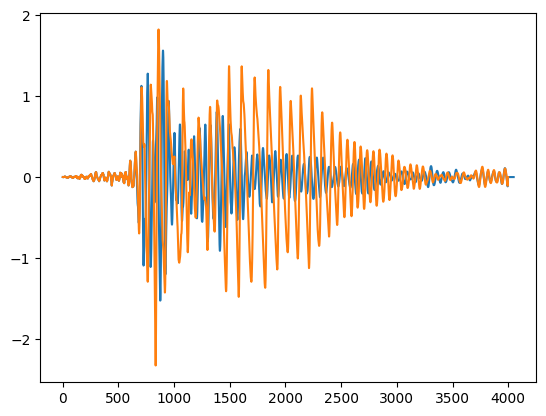

In [13]:
plt.plot(xo[:,15,4])
plt.plot(xon[:,15,4])

In [162]:
# LQR (Nonlinear structure)
# Yield parameters
An = A
Cdn = Cd
# Time series analysis
(i,j) = Cd.shape
xpn = np.zeros((4000,2*n,10))
ypn = np.zeros((4000,i,10))
J2n_val = np.zeros([10, 1])
Un = np.zeros([4000, r, 10])
Epn = np.zeros([4050, 1, 10])
GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])

del i,j
for i in range(0, 10):
    if GM[i] < 10:
        f = "la"+"%02d" % GM[i]  + ".dat"
    else:
        f = "la"+"%02d" % GM[i]  + ".dat"
    print(f)
    xacc = (np.array(np.loadtxt(f)).flatten())/100
    # Time series for ground motion
    dt = GMdt[GM[i]-1]
    print(dt)
    tend = dt*len(xacc)
    t = np.arange(0, tend, dt)
    #plt.figure()
    #plt.plot(t,xacc)

    for tkk in range(0,len(t)-1):
        time_current = t[tkk]
        # System nonlinearity
        K1 = 3444*10**5
        Dy = 0.012
        Fy = K1*Dy
        # Uncontrolled
        if(xpn[tkk,0,i]>=Dy):

            kk = Fy/xpn[tkk,0,i]
            #print(xpn[tkk,0,i], kk)
            Kn = 2*np.diag(np.full(n,kk))
            Kn[n-1,n-1] = kk
            for x in range(n-1):
              Kn[x,x+1] = -kk
              Kn[x+1,x] = -kk
            A3n = -1*np.linalg.inv(M) @ Kn
            An[n:2*n,0:n] = A3n
            Cdn[0:n, 0:n] = A3n
            d_system_n = cont2discrete((An, np.concatenate((B, E), axis=1), Cdn, np.concatenate((Dd, Ed1), axis=1)), dt, method='zoh')
            Adn = d_system_n[0]
            Bd1 = d_system_n[1]
            Bdn = Bd1[:,0:3]
            Edn = Bd1[:,3:4]
            del kk, Kn, A3n
            # Control Results
            y1n = (Cdn @ np.array([xpn[tkk,:,i]]).T) + (Dd @ ((-1*Kp) @ np.array([xpn[tkk,:,i]]).T))
            ypn[tkk,:,i] = y1n.T
            un = (-1*Kp) @ np.array([xpn[tkk,:,i]]).T
            #print(u)
            Un[tkk, :, i] = un.T
            x1n = (Adn @ np.array([xpn[tkk,:,i]]).T) + (Bdn @ ((-1*Kp) @ np.array([xpn[tkk,:,i]]).T)) + (Edn * xacc[tkk])
            xpn[tkk+1,:,i] = x1n.T
            del Adn, Bdn, Edn
        else:
            y1n = (Cd @ np.array([xpn[tkk,:,i]]).T) + (Dd @ ((-1*Kp) @ np.array([xpn[tkk,:,i]]).T))
            ypn[tkk,:,i] = y1n.T
            un = (-1*Kp) @ np.array([xpn[tkk,:,i]]).T
            #print(u)
            Un[tkk, :, i] = un.T
            x1n = (Ad @ np.array([xpn[tkk,:,i]]).T) + (Bd @ ((-1*Kp) @ np.array([xpn[tkk,:,i]]).T)) + (Ed * xacc[tkk])
            xpn[tkk+1,:,i] = x1n.T    
        
        En2n = 0.5*((xpn[tkk+1,:,i]@Q)@xpn[tkk+1,:,i].T)
        Epn[tkk+1,:,i-1] = En2n
        J2n = dt*En2n
        J2n_val[i] += J2n
print(J2n_val) 

la01.dat
0.02
la02.dat
0.02
la07.dat
0.02
la08.dat
0.02
la09.dat
0.02
la10.dat
0.02
la11.dat
0.02
la12.dat
0.02
la13.dat
0.02
la14.dat
0.02
[[1.96514103]
 [2.50619251]
 [0.91430967]
 [1.00696544]
 [3.12754248]
 [1.43247997]
 [1.47336295]
 [1.21519396]
 [1.93449591]
 [4.10711863]]


In [170]:
# LQR (Nonlinear structure) (case 2)
# Yield parameters
An = A
Cdn = Cd
# Time series analysis
(i,j) = Cd.shape
xpn1 = np.zeros((4000,2*n,10))
ypn1 = np.zeros((4000,i,10))
J2n_val1 = np.zeros([10, 1])
Un1 = np.zeros([4000, r, 10])
Epn1 = np.zeros([4000, 1, 10])
GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])

del i,j
for i in range(0, 10):
    if GM[i] < 10:
        f = "la"+"%02d" % GM[i]  + ".dat"
    else:
        f = "la"+"%02d" % GM[i]  + ".dat"
    print(f)
    xacc = (np.array(np.loadtxt(f)).flatten())/100
    # Time series for ground motion
    dt = GMdt[GM[i]-1]
    print(dt)
    tend = dt*len(xacc)
    t = np.arange(0, tend, dt)
    #plt.figure()
    #plt.plot(t,xacc)

    for tkk in range(0,len(t)-1):
        time_current = t[tkk]
        # System nonlinearity
        K1 = 3444*10**5
        Dy = 0.008
        Fy = K1*Dy
        # Uncontrolled
        if(xpn1[tkk,0,i]>=Dy):

            kk = Fy/xpn1[tkk,0,i]
            #print(xpn[tkk,0,i], kk)
            Kn = 2*np.diag(np.full(n,kk))
            Kn[n-1,n-1] = kk
            for x in range(n-1):
              Kn[x,x+1] = -kk
              Kn[x+1,x] = -kk
            A3n = -1*np.linalg.inv(M) @ Kn
            An[n:2*n,0:n] = A3n
            Cdn[0:n, 0:n] = A3n
            d_system_n = cont2discrete((An, np.concatenate((B, E), axis=1), Cdn, np.concatenate((Dd, Ed1), axis=1)), dt, method='zoh')
            Adn = d_system_n[0]
            Bd1 = d_system_n[1]
            Bdn = Bd1[:,0:3]
            Edn = Bd1[:,3:4]
            del kk, Kn, A3n
            # Control Results
            y1n = (Cdn @ np.array([xpn1[tkk,:,i]]).T) + (Dd @ ((-1*Kp) @ np.array([xpn1[tkk,:,i]]).T))
            ypn1[tkk,:,i] = y1n.T
            un = (-1*Kp) @ np.array([xpn1[tkk,:,i]]).T
            #print(u)
            Un1[tkk, :, i] = un.T
            x1n = (Adn @ np.array([xpn1[tkk,:,i]]).T) + (Bdn @ ((-1*Kp) @ np.array([xpn1[tkk,:,i]]).T)) + (Edn * xacc[tkk])
            xpn1[tkk+1,:,i] = x1n.T
            del Adn, Bdn, Edn
        else:
            y1n = (Cd @ np.array([xpn1[tkk,:,i]]).T) + (Dd @ ((-1*Kp) @ np.array([xpn1[tkk,:,i]]).T))
            ypn1[tkk,:,i] = y1n.T
            un = (-1*Kp) @ np.array([xpn1[tkk,:,i]]).T
            #print(u)
            Un1[tkk, :, i] = un.T
            x1n = (Ad @ np.array([xpn1[tkk,:,i]]).T) + (Bd @ ((-1*Kp) @ np.array([xpn1[tkk,:,i]]).T)) + (Ed * xacc[tkk])
            xpn1[tkk+1,:,i] = x1n.T    
        
        En2n = 0.5*((xpn1[tkk+1,:,i]@Q)@xpn1[tkk+1,:,i].T)
        Epn1[tkk+1,:,i-1] = En2n
        J2n1 = dt*En2n
        J2n_val1[i] += J2n1
print(J2n_val1) 

la01.dat
0.02
la02.dat
0.02


C:\Users\91735\AppData\Local\Temp\ipykernel_13956\1959446991.py:73: RuntimeWarning: overflow encountered in matmul
  En2n = 0.5*((xpn1[tkk+1,:,i]@Q)@xpn1[tkk+1,:,i].T)


la07.dat
0.02
la08.dat
0.02
la09.dat
0.02
la10.dat
0.02
la11.dat
0.02
la12.dat
0.02
la13.dat
0.02
la14.dat
0.02
[[1.85445380e+000]
 [            inf]
 [8.63271763e-001]
 [9.14285865e-001]
 [            inf]
 [1.37275528e+000]
 [2.11420240e+267]
 [1.16681179e+000]
 [            inf]
 [            inf]]


In [82]:
#  Performance indices
J1rp = np.zeros([10, n])
J2rp = np.zeros([10, n])
J3rp = np.zeros([10, n])
J4rp = np.zeros([10, 1])
J5rp = np.zeros([10, r])
#  Variation along height
J1p = np.zeros([1, n])
J2p = np.zeros([1, n])
J3p = np.zeros([1, n])
J4p = np.zeros([1, 1])
J5p = np.zeros([1, r])

In [83]:
for ijk in range(0,10):
    J4rp[ijk, :] = max(np.absolute(Epn[:,0,ijk]))/max(np.absolute(Eon[:,0,ijk]))
    for i in range(0,n):
        J1rp[ijk, i] = max(np.absolute(xpn[:,i,ijk]))/max(np.absolute(xon[:,i,ijk]))
        J2rp[ijk, i] = max(np.absolute(xpn[:,n+i,ijk]))/max(np.absolute(xon[:,n+i,ijk]))
        J3rp[ijk, i] = max(np.absolute(ypn[:,i,ijk]))/max(np.absolute(yon[:,i,ijk]))
    for l in range(0,r):
        J5rp[ijk, l] = max(np.absolute(Un[:,l,ijk]))/(345600*10*8)

del i, ijk
J4p[:, :] = np.mean(J4rp[:, 0])
for i in range(0,n):
    J1p[:, i] = np.mean(J1rp[:, i])
    J2p[:, i] = np.mean(J2rp[:, i])
    J3p[:, i] = np.mean(J3rp[:, i])
for i in range(0,r):
    J5p[:, i] = np.mean(J5rp[:, i])

In [84]:
J1p

array([[0.22232082, 0.19798607, 0.21991277, 0.19677759, 0.20988242,
        0.20125367, 0.2083779 , 0.21343953]])

In [85]:
J2p

array([[0.980056  , 0.5704069 , 0.63176246, 0.57760274, 0.57603195,
        0.5261421 , 0.50552803, 0.51935773]])

In [86]:
J3p*0.25

array([[0.64348792, 0.26858331, 0.42873849, 0.49109296, 0.33140751,
        0.33230279, 0.20707881, 0.2086872 ]])

In [87]:
J4p

array([[0.43062645]])

In [88]:
J5p

array([[0.32258063, 0.28604755, 0.18723837]])

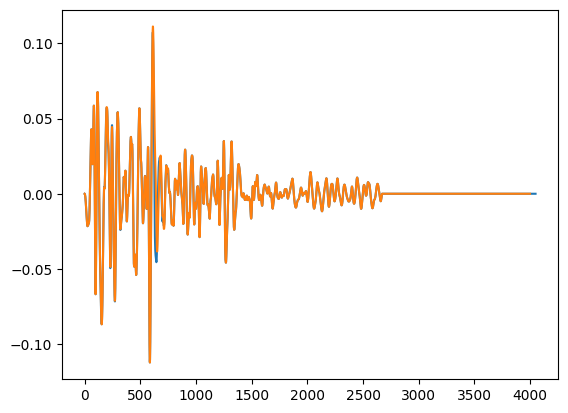

In [15]:
plt.plot(xp[:,7,0])
plt.plot(xpn[:,7,0])

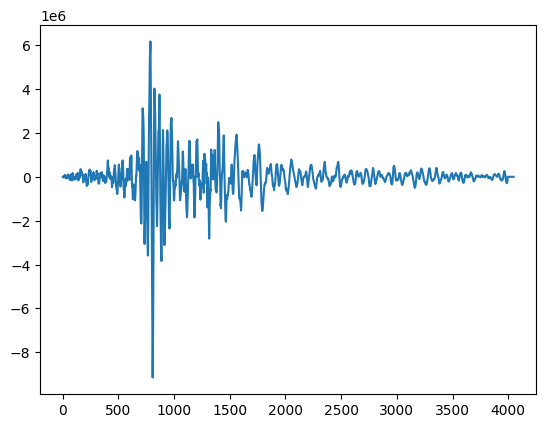

In [16]:
plt.plot(U[:,0,2])

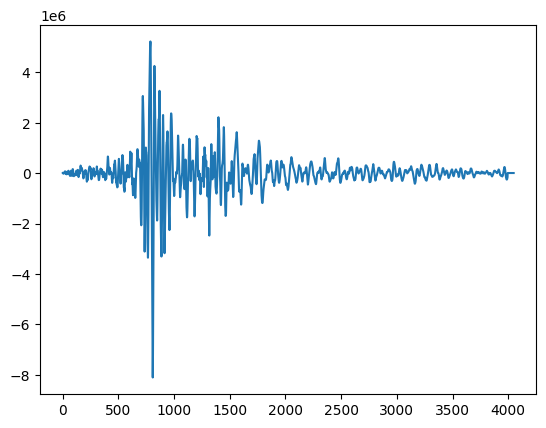

In [17]:
plt.plot(U[:,1,2])

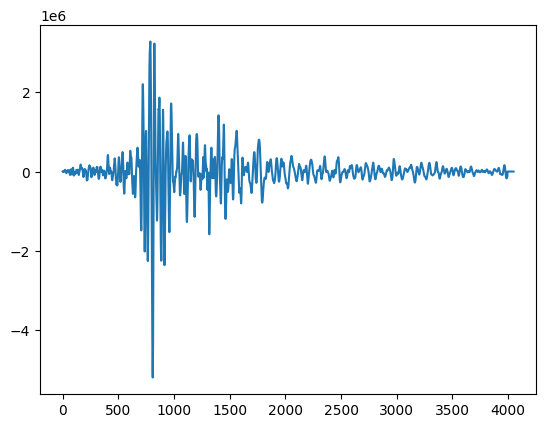

In [18]:
plt.plot(U[:,2,2])

In [19]:
# sr = 1/dt  # sampling frequency
# N1 = 2048  # Number of samples
# fstep = sr/N1  # freq interval
# f = np.linspace(0, (N1-1)*fstep, N1)

# # Perform FFT
# X = np.fft.fft(c)
# X_mag = np.abs(X)/N1

# f_plot = f[0:int(N1/2+1)]/(2 * np.pi)
# X_mag_plot = 2*X_mag[0:int(N1/2+1)]
# X_mag_plot[0] = X_mag_plot[0] / 2 # DC component does not need to multiply by 2

# # Plot 
# fig, ax1 = plt.subplots(nrows=1, ncols=1)
# ax1.plot(f_plot, X_mag_plot, '.-')
# ax1.set_xlabel('Freq (Hz)')
# ax1.set_ylabel('FFT Amplitude |X(freq)|')
# ax1.semilogx()
# ax1.set_xlim(0, 100)
# plt.show()

In [101]:
class MrDamperEnv(Env):

    def __init__(self):
    
      self.n = 8    # Number of storey
      self.r = 3    # no of MR dampers
      # 1000kN MR damper
      self.vmax = 10
      self.vmin = 0
      self.gamma = 141
      self.beta = 141
      self.Ad = 2074.5
      self.nd = 2
      self.eta = 100
      self.alpha0 = 26.0*10**3
      self.alpha1 = 29.1*10**3
      self.c01 = 105.4*10**3
      self.c02 = 131.6*10**3
      self.k01 = 0
      self.k02 = 0

      
      # Plant matrices (Continous)
      self.A = np.load('A1.npy')
      self.B = np.load('B1.npy')
      self.E = np.load('E1.npy')
      self.Cd = np.load('Cd1.npy')
      self.Dd = np.load('Dd1.npy')
      self.Ed1 = np.load('Ed1.npy')
      self.M = np.load('M.npy')
      self.C = np.load('C.npy')
      self.K = np.load('K.npy')
      self.An = self.A
      self.Cdn = self.Cd
        
      # Plant matrices (discrete) 
      d_system = cont2discrete((self.A, np.concatenate((self.B, self.E), axis=1), self.Cd, np.concatenate((self.Dd, self.Ed1), axis=1)), 0.02, method='zoh')
      self.Ad = d_system[0]
      Bd1 = d_system[1]
      self.Bd = Bd1[:,0:3]
      self.Ed = Bd1[:,3:4]
          
      # Weighting matrices
      self.Q = np.identity(2*self.n)
      #self.Q = np.zeros([2*self.n, 2*self.n])
      #self.Q[0:self.n, 0:self.n] = self.K
      #self.Q[self.n:2*self.n, self.n:2*self.n] = self.M
      (i,j) = self.B.shape
      self.R =  (10**(-14))*np.identity(j)
      del i, j

      # Output matrix (Disp + Accel)
      #self.Cd = np.array([[1, 1, 0, 0], [-self.Ks/self.M, self.Ks/self.M, 0, 0], [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
      #self.Dd = np.array([[0, 1/self.M, -1/self.m]]).T
      #self.Ed = np.array([[0, 0, 0]]).T
    
              
      # Input per episode
      GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])
      a = np.random.randint(low=1,high=10)

      if a < 10:
        f = "la"+"%02d" % GM[a]  + ".dat"
      else:
        f = "la"+"%02d" % GM[a]  + ".dat"
      #print(f)
      self.xacc = (np.array(np.loadtxt(f)).flatten())/100  # Convert cm/s2 to m/s2
      #print(c)
      
      # Time series for ground motion
      GMdt = np.loadtxt('GMdt.txt', unpack = True)
      #print(len(GMdt))
      self.dt = GMdt[GM[a]-1]
      #print(self.dt)
      tend = self.dt*len(self.xacc)
      self.t = np.arange(0, tend, self.dt)
      nt = self.t.size
      #plt.figure()
      #plt.plot(self.t, self.xacc)
      del a, f, GMdt, tend   
      
          
      # Initialize variables
      self.time_current = 0
      self.state = np.zeros([nt, 2*self.n]) # states (ys,ysdot,yt,ytdot)
      self.U = np.zeros([nt, self.r]) # Control force (action)
      self.Re = np.zeros([nt, 1]) # Reward
      self.J_val = 0
      self.action_space = Box(low=np.array([-6e6, -6e6, -6e6]), high=np.array([6e6, 6e6, 6e6]),shape=(3,))
      self.observation_space = Box(low=np.array([-100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000]), high=np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]) )
      self.statem = np.zeros([1, 2*self.n])
      self.hr = []

    def step(self, action):
          tim = self.time_current  # current time (size 1)
          # Control action
          #print(action)
          self.U[tim, :] = np.squeeze(action)    # control force
          #self.U[tim, 1] = np.squeeze(action)    # control force (floor 4)
          #self.U[tim, 2] = np.squeeze(action)    # control force (floor 6)
          
          action1 = np.array([self.U[tim, :]]).T
          state = np.array([self.state[tim, :]]).T
          #print(action1)
          #print(tim, self.U[tim, :], self.state[tim, :], self.Re[tim, :])
          
          # System model in discrete time
          Q = self.Q
          R = self.R  
          n = self.n
          r = self.r
          M = self.M 
          dt = self.dt
        
          self.J = 0
          z = 10 + tim
          i = 0
          for tkk in range(tim, z):
            h = self.xacc[tkk] 
            self.hr.append(h)
            xn = state
            #print(xn)
            K1 = 3444*10**5
            Dy = 0.012
            Fy = K1*Dy
            # Uncontrolled
            if(xn[0,0]>=Dy):

                kk = Fy/xn[0,0]
                #print(xpn[tkk,0,i], kk)
                Kn = 2*np.diag(np.full(n,kk))
                Kn[n-1,n-1] = kk
                for x in range(n-1):
                  Kn[x,x+1] = -kk
                  Kn[x+1,x] = -kk
                A3n = -1*np.linalg.inv(M) @ Kn
                self.An[n:2*n,0:n] = A3n
                self.Cdn[0:n, 0:n] = A3n
                d_system_n = cont2discrete((self.An, np.concatenate((self.B, self.E), axis=1), self.Cdn, np.concatenate((self.Dd, self.Ed1), axis=1)), dt, method='zoh')
                Adn = d_system_n[0]
                Bd1 = d_system_n[1]
                Bdn = Bd1[:,0:3]
                Edn = Bd1[:,3:4]
                del kk, Kn, A3n
                # Control Results
                yn1 = (self.Cdn @ xn) + (self.Dd @ action1)
                xn1 = (Adn @ xn) + (Bdn @ action1) + (Edn * h)
                del Adn, Bdn, Edn
            else:
                yn1 = (self.Cd @ xn) + (self.Dd @ action1)
                xn1 = (self.Ad @ xn) + (self.Bd @ action1) + (self.Ed * h)    
                state = xn1

            self.En = 0.5*((state.T@Q)@state)
            #print(self.E)
            self.J = self.J + dt*(0.9**i)*(self.En)
            
            if(i==0):
              self.statem = state.T
              self.J_val += self.J 
            i = i+1
          #print("kkk ",self.J_val)
          #print(self.J) 
          done = False
          #print(f1)
          info = {}   
          reward = -1*self.J
          self.Re[tim+1, :] = reward
          self.state[tim+1, :] = self.statem

          return self.statem[0], reward, done, info

    def reset(self):
    
      self.n = 8    # Number of storey
      self.r = 3    # no of MR dampers
      # 1000kN MR damper
      self.vmax = 10
      self.vmin = 0
      self.gamma = 141
      self.beta = 141
      self.Ad = 2074.5
      self.nd = 2
      self.eta = 100
      self.alpha0 = 26.0*10**3
      self.alpha1 = 29.1*10**3
      self.c01 = 105.4*10**3
      self.c02 = 131.6*10**3
      self.k01 = 0
      self.k02 = 0

      
      # Plant matrices (Continous)
      self.A = np.load('A1.npy')
      self.B = np.load('B1.npy')
      self.E = np.load('E1.npy')
      self.Cd = np.load('Cd1.npy')
      self.Dd = np.load('Dd1.npy')
      self.Ed1 = np.load('Ed1.npy')
      self.M = np.load('M.npy')
      self.C = np.load('C.npy')
      self.K = np.load('K.npy')
      self.An = self.A
      self.Cdn = self.Cd
        
      # Plant matrices (discrete) 
      d_system = cont2discrete((self.A, np.concatenate((self.B, self.E), axis=1), self.Cd, np.concatenate((self.Dd, self.Ed1), axis=1)), 0.02, method='zoh')
      self.Ad = d_system[0]
      Bd1 = d_system[1]
      self.Bd = Bd1[:,0:3]
      self.Ed = Bd1[:,3:4]
          
      # Weighting matrices
      self.Q = np.identity(2*self.n)
      #self.Q = np.zeros([2*self.n, 2*self.n])
      #self.Q[0:self.n, 0:self.n] = self.K
      #self.Q[self.n:2*self.n, self.n:2*self.n] = self.M
      (i,j) = self.B.shape
      self.R =  (10**(-14))*np.identity(j)
      del i, j

      # Output matrix (Disp + Accel)
      #self.Cd = np.array([[1, 1, 0, 0], [-self.Ks/self.M, self.Ks/self.M, 0, 0], [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
      #self.Dd = np.array([[0, 1/self.M, -1/self.m]]).T
      #self.Ed = np.array([[0, 0, 0]]).T
    
              
      # Input per episode
      GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])
      a = np.random.randint(low=1,high=10)

      if a < 10:
        f = "la"+"%02d" % GM[a]  + ".dat"
      else:
        f = "la"+"%02d" % GM[a]  + ".dat"
      #print(f)
      self.xacc = (np.array(np.loadtxt(f)).flatten())/100  # Convert cm/s2 to m/s2
      #print(c)
      
      # Time series for ground motion
      GMdt = np.loadtxt('GMdt.txt', unpack = True)
      #print(len(GMdt))
      self.dt = GMdt[GM[a]-1]
      #print(self.dt)
      tend = self.dt*len(self.xacc)
      self.t = np.arange(0, tend, self.dt)
      nt = self.t.size
      #plt.figure()
      #plt.plot(self.t, self.xacc)
      del a, f, GMdt, tend   
      
          
      # Initialize variables
      self.time_current = 0
      self.state = np.zeros([nt, 2*self.n]) # states (ys,ysdot,yt,ytdot)
      self.U = np.zeros([nt, self.r]) # Control force (action)
      self.Re = np.zeros([nt, 1]) # Reward
      self.J_val = 0
      self.action_space = Box(low=np.array([-6e6, -6e6, -6e6]), high=np.array([6e6, 6e6, 6e6]),shape=(3,))
      self.observation_space = Box(low=np.array([-100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000]), high=np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]) )
      self.statem = np.zeros([1, 2*self.n])
      self.hr = []
      return self.state[0, :]


env = MrDamperEnv()

In [102]:
states = env.observation_space.shape
num_states = states[0]
print("Size of State Space ->  {}".format(num_states))
actions = env.action_space.shape
num_actions = actions[0]
print("Size of Action Space ->  {}".format(num_actions))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  16
Size of Action Space ->  3
Max Value of Action ->  6000000.0
Min Value of Action ->  -6000000.0


In [103]:
env.action_space.sample()

array([ 3820600. , -1085640.1, -2736427.5], dtype=float32)

In [104]:
env.observation_space.sample()

array([-25460.492 ,  -2404.5981, -26474.625 , -23560.26  ,  70934.28  ,
        77549.31  ,  90025.36  , -66241.75  , -46334.914 , -51791.203 ,
        48206.46  , -51094.29  , -40565.707 ,  32522.6   ,  77820.24  ,
        78969.95  ], dtype=float32)

In [105]:
# # Reward list
# ep_reward_list = np.zeros([env.t.size, 10]) 
# ep_reward_list1 = []
# avg_reward_list = []
# #  Cost function 
# ep_Jval_list = np.zeros([10, 1])
# #  Action and state 
# ep_Action_list= np.zeros([env.t.size, 10])
# ep_State_list = np.zeros([env.t.size, 2*env.n, 10])
# for ep in range(10):
#     prev_state = env.reset()
#     episodic_reward = 0
#     for tim in range(0,len(env.t)-20): 
#         env.time_current = tim
#         #tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
#         action = env.action_space.sample()
#         state, reward, done, info = env.step(action)
#         episodic_reward += reward
#         prev_state = state
#         #print('tim:{} action:{} reward:{} state:{}'.format(tim, action, reward, state))
    
#     ep_Action_list[:, ep] = np.squeeze(env.U)
#     ep_State_list[:, :, ep] = env.state
#     ep_reward_list[:, ep] = np.squeeze(env.Re)
    
    
#     ep_Jval_list[ep, :] = np.array([env.J_val])
#     ep_reward_list1.append(episodic_reward)
#     avg_reward = np.mean(ep_reward_list1[-40:])
#     avg_reward_list.append(avg_reward)
#     print(env.J_val)
#     print("Episode * {} * Reward is ==> {} * J_value is ==> {}".format(ep, episodic_reward, env.J_val))

In [106]:
 class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = ( self.x_prev+ self.theta * (self.mean - self.x_prev) * self.dt + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape))
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [107]:
 class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size
        
        # Its tells us num of times record() was called.
        self.buffer_counter = 0
        
        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
    
    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
      
        index = self.buffer_counter % self.buffer_capacity
        
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1


    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
       
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [108]:
 def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(3, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(3)(out)
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [109]:
 def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [65]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.001
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
gamma = 0.0001
tau = 0.05

buffer = Buffer(100000, 64)

In [67]:
# Reward list
ep_reward_list = np.zeros([4000, 1, total_episodes]) 
ep_reward_list1 = []
avg_reward_list = []
#  Cost function 
ep_Jval_list = np.zeros([total_episodes, 1])
#  Action and state 
ep_Action_list = np.zeros([4000, env.r, total_episodes])
ep_State_list = np.zeros([4000, 2*env.n, total_episodes])

for ep in range(total_episodes):
    prev_state = env.reset()
    episodic_reward = 0
    nt = len(env.t)
    for time in range(0,nt-10):
        env.time_current = time
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        #print(action)
        # Action List
        state, reward, done, info = env.step(action)
        #print(action)
        buffer.record((prev_state, np.squeeze(action), reward, state))
        episodic_reward += reward
        # Reward list
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        prev_state = state     
    
    ep_Action_list[0:nt, :, ep] = np.squeeze(env.U)
    ep_State_list[0:nt, :, ep] = env.state
    ep_reward_list[0:nt, :, ep] = env.Re
    
    
    ep_Jval_list[ep, :] = np.array([env.J_val])
    ep_reward_list1.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list1[-40:])
    avg_reward_list.append(avg_reward)
    print("Episode * {} * Reward is ==> {} * J_value is ==> {}".format(ep, episodic_reward, env.J_val))
    #     print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
    
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
plt.plot(ep_reward_list1)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()

np.savetxt("8_story_nonlinear_M.txt",ep_reward_list.flatten())
np.savetxt("8_story_avg_nonlinear_M.txt",avg_reward_list.flatten())

Episode * 0 * Reward is ==> [[-106.80053518]] * J_value is ==> [[16.36362084]]
Episode * 1 * Reward is ==> [[-10.64065574]] * J_value is ==> [[1.63244188]]
Episode * 2 * Reward is ==> [[-37.56557827]] * J_value is ==> [[5.76713032]]
Episode * 3 * Reward is ==> [[-34.73101239]] * J_value is ==> [[5.33193657]]
Episode * 4 * Reward is ==> [[-24.57506104]] * J_value is ==> [[3.77257921]]
Episode * 5 * Reward is ==> [[-54.64674729]] * J_value is ==> [[8.39026201]]
Episode * 6 * Reward is ==> [[-63.26259954]] * J_value is ==> [[9.71269559]]
Episode * 7 * Reward is ==> [[-80.60656422]] * J_value is ==> [[12.37655745]]
Episode * 8 * Reward is ==> [[-55.51936271]] * J_value is ==> [[8.52478741]]
Episode * 9 * Reward is ==> [[-81.3889591]] * J_value is ==> [[12.49672365]]
Episode * 10 * Reward is ==> [[-81.4098973]] * J_value is ==> [[12.49994031]]
Episode * 11 * Reward is ==> [[-60.71862513]] * J_value is ==> [[9.32315006]]
Episode * 12 * Reward is ==> [[-81.38895592]] * J_value is ==> [[12.496

Episode * 105 * Reward is ==> [[-40.22453156]] * J_value is ==> [[6.17658795]]
Episode * 106 * Reward is ==> [[-60.718621]] * J_value is ==> [[9.32314943]]
Episode * 107 * Reward is ==> [[-60.71862097]] * J_value is ==> [[9.32314942]]
Episode * 108 * Reward is ==> [[-81.13428567]] * J_value is ==> [[12.45763182]]
Episode * 109 * Reward is ==> [[-81.40989939]] * J_value is ==> [[12.49994063]]
Episode * 110 * Reward is ==> [[-55.51936349]] * J_value is ==> [[8.52478753]]
Episode * 111 * Reward is ==> [[-60.66771775]] * J_value is ==> [[9.31533177]]
Episode * 112 * Reward is ==> [[-81.38895377]] * J_value is ==> [[12.49672283]]
Episode * 113 * Reward is ==> [[-40.22453158]] * J_value is ==> [[6.17658796]]
Episode * 114 * Reward is ==> [[-81.13428683]] * J_value is ==> [[12.457632]]
Episode * 115 * Reward is ==> [[-81.40989818]] * J_value is ==> [[12.49994045]]
Episode * 116 * Reward is ==> [[-40.55377062]] * J_value is ==> [[6.22715339]]
Episode * 117 * Reward is ==> [[-55.51936373]] * J_

KeyboardInterrupt: 

In [39]:
np.savetxt("8story_nonlinear.txt",ep_reward_list.flatten())
np.savetxt("8story_avg_nonlinear.txt",avg_reward_list)
np.savetxt("8story_ep_Jval_list_N.txt",ep_Jval_list)
np.save('8story_ep_Action_list_N.npy', ep_Action_list)
np.save('8story_ep_State_list_N.npy', ep_State_list)
np.save('8story_ep_reward_list_N.npy', ep_reward_list) 

In [ ]:

 [0.91430967]
 [1.00696544]
 [3.12754248]
 [1.43247997]
 [1.47336295]
 [1.21519396]
 [1.93449591[[1.96514103]
 [2.50619251]]
 [4.10711863]]

In [40]:
# Save the weights
actor_model.save_weights("8story_actor_DDPG_G0p0001T0p9_N.h5")
critic_model.save_weights("8story_critic_DDPG_G0p0001T0p9_N.h5")

target_actor.save_weights("8story_target_actor_DDPG_G0p0001T0p9_N.h5")
target_critic.save_weights("8story_target_critic_DDPG_G0p0001T0p9_N.h5")

In [110]:
del actor_model 
del critic_model

del target_actor 
del target_critic 
del policy

NameError: name 'actor_model' is not defined

In [111]:
 def policy(state):
    sampled_actions = tf.squeeze(target_actor(state))
   
    sampled_actions = sampled_actions.numpy() 
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [112]:
target_actor = get_actor()
target_actor.load_weights("8story_target_actor_DDPG_G0p0001T0p9_N.h5")

In [113]:
# Time series analysis
xd = np.zeros((4000,2*n,10))
yd = np.zeros((4000,n,10))
Action = np.zeros([4000, r, 10])
Action1 = np.zeros([4000, r, 10])
Ed = np.zeros([4000, 1, 10])
ep = 1000-1

GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])
for i in range(0, 10):
    prev_state = env.reset()
    if GM[i] < 10:
        f = "la"+"%02d" % GM[i]  + ".dat"
    else:
        f = "la"+"%02d" % GM[i]  + ".dat"
    print(f)
    xacc = (np.array(np.loadtxt(f)).flatten())/100
    # Time series for ground motion
    dt = GMdt[GM[i]-1]
    env.dt = dt
    #print(dt)
    tend = dt*len(xacc)
    t = np.arange(0, tend, dt)
    env.t = t
    #plt.figure()
    #plt.plot(t,xacc)
    env.xacc = xacc
    episodic_reward = 0
    nt = len(env.t)
    env.time_current = 0
    env.state = np.zeros([nt, 2*env.n]) # states (ys,ysdot,yt,ytdot)
    env.U = np.zeros([nt, env.r]) # Control force (action)
    env.Re = np.zeros([nt, 1]) # Reward
    for time in range(0,nt-10):
        
        env.time_current = time
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state)
        #print(action)
        # Action List
        state, reward, done, info = env.step(action)
        #print(action)
        episodic_reward += reward
        # Reward list
        prev_state = state
        
    #print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
    print("Episode * {} * J_value is ==> {}".format(ep, env.J_val)) 
    xd[0:nt, :, i] = env.state
    Action[0:nt, :, i] = np.squeeze(env.U)
  
    for tkk in range(0,nt-1):
        En1 = 0.5*((np.array([xd[tkk, :, i]]) @ Q)@ (np.array([xd[tkk, :, i]])).T)
        Ed[tkk,:,i] = En1
        u1 = (-1*Kp)@np.array([xd[tkk, :, i]]).T
        Action1[tkk, :, i] = u1.T
        y1 = (Cd @ np.array([xd[tkk,:,i]]).T) + (Dd@np.array([Action[tkk, :, i]]).T)
        yd[tkk, :, i] = y1[0:8].T

la01.dat
Episode * 999 * J_value is ==> [[4.5380838]]
la02.dat
Episode * 999 * J_value is ==> [[68.62500237]]
la07.dat
Episode * 999 * J_value is ==> [[19.8326867]]
la08.dat
Episode * 999 * J_value is ==> [[2.5940759]]
la09.dat
Episode * 999 * J_value is ==> [[1.10902403]]
la10.dat
Episode * 999 * J_value is ==> [[3.57112947]]
la11.dat
Episode * 999 * J_value is ==> [[3.38038875]]
la12.dat
Episode * 999 * J_value is ==> [[16.53536509]]
la13.dat
Episode * 999 * J_value is ==> [[59.08640029]]
la14.dat
Episode * 999 * J_value is ==> [[256.80778608]]


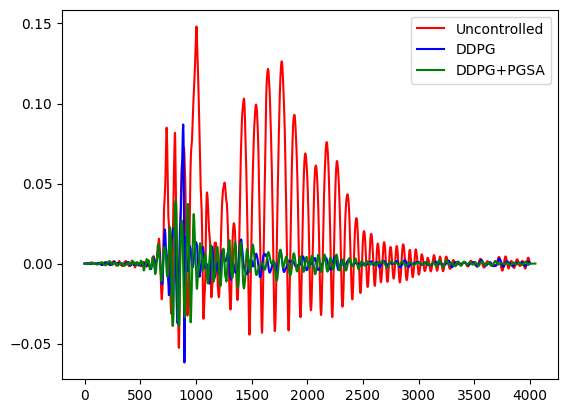

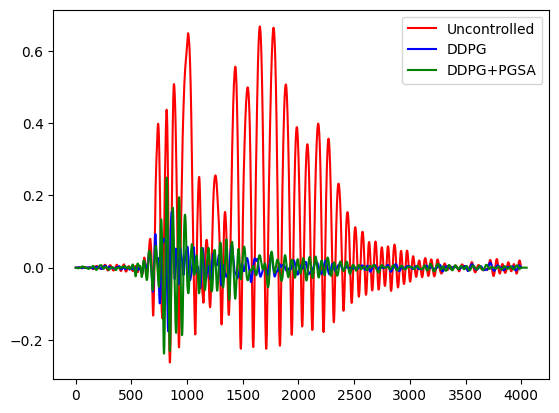

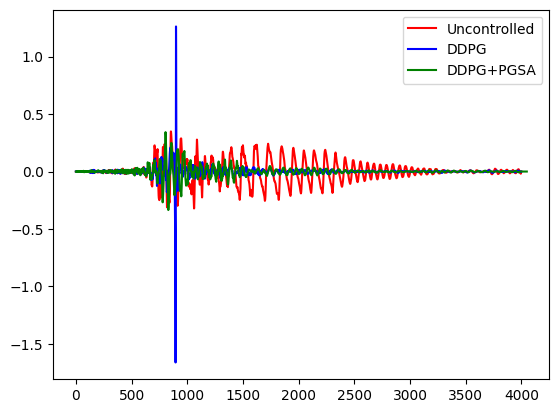

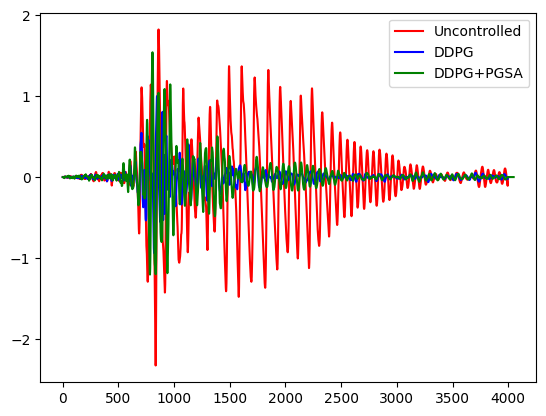

In [194]:
#  Control force
plt.figure()
plt.plot(xon[:,0, 4],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(xpn[:,0, 4],'b',label='DDPG')
plt.plot(xp[:,0, 7],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xon[:,7, 4],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(xpn[:,7, 4],'b',label='DDPG')
plt.plot(xp[:,7, 7],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xon[:,8, 4],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(xpn[:,8, 4],'b',label='DDPG')
plt.plot(xp[:,8, 7],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xon[:,15, 4],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(xpn[:,15, 4],'b',label='DDPG')
plt.plot(xp[:,15, 7],'g',label='DDPG+PGSA')
plt.legend()



In [198]:
dt = GMdt[8]
tend = dt*4000
t = np.arange(0, tend, dt)

In [205]:
input = np.array([t, xon[:,7, 4], xpn[:,7, 4], xon[:,15, 4], xpn[:,15, 4], yon[:,7, 4], ypn[:,7, 4]])
print(input.T.shape)
result=np.savetxt('Response1_NonLinear.txt', input.T, delimiter=' ')
print(result)

input = np.array([xp[:,7, 7], xp[:,15, 7], yp[:,7, 7]])
print(input.T.shape)
result=np.savetxt('Response2_NonLinear.txt', input.T, delimiter=' ')
print(result)

(4000, 7)
None
(4050, 3)
None


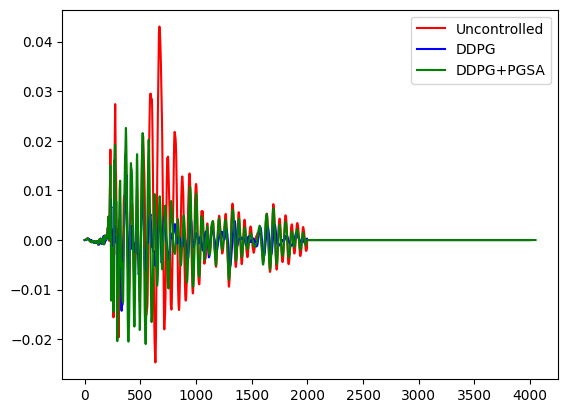

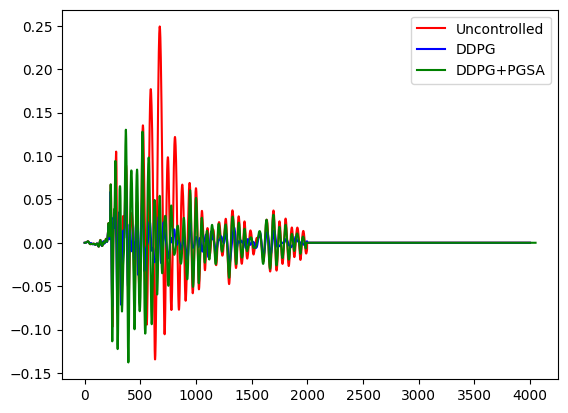

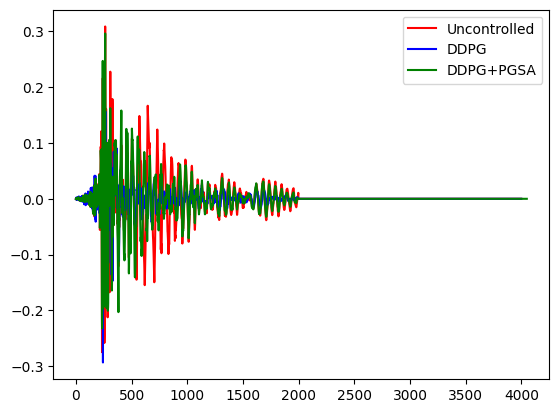

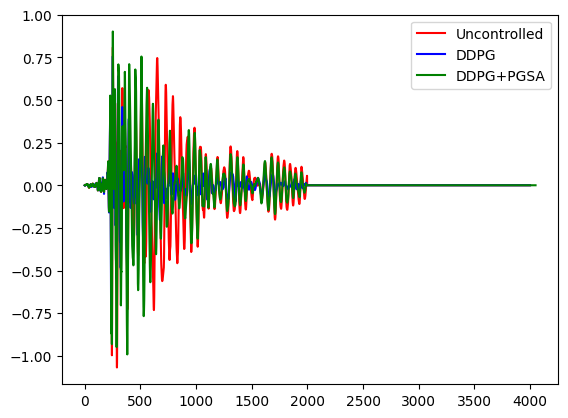

In [186]:
plt.figure()
plt.plot(xon[:,0, 7],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(xpn[:,0, 7],'b',label='DDPG')
plt.plot(xp[:,0, 11],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xon[:,7, 7],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(xpn[:,7, 7],'b',label='DDPG')
plt.plot(xp[:,7, 11],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xon[:,8, 7],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(xpn[:,8, 7],'b',label='DDPG')
plt.plot(xp[:,8, 11],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xon[:,15, 7],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(xpn[:,15, 7],'b',label='DDPG')
plt.plot(xp[:,15, 11],'g',label='DDPG+PGSA')
plt.legend()


In [203]:
dt = GMdt[11]
tend = dt*4000
t = np.arange(0, tend, dt)

In [206]:
input = np.array([t, xon[:,7, 7], xpn[:,7, 7], xon[:,15, 7], xpn[:,15, 7], yon[:,7, 7], ypn[:,7, 7]])
print(input.T.shape)
result=np.savetxt('Response3_NonLinear.txt', input.T, delimiter=' ')
print(result)

input = np.array([xp[:,7, 11], xp[:,15, 11], yp[:,7, 11]])
print(input.T.shape)
result=np.savetxt('Response4_NonLinear.txt', input.T, delimiter=' ')
print(result)

(4000, 7)
None
(4050, 3)
None


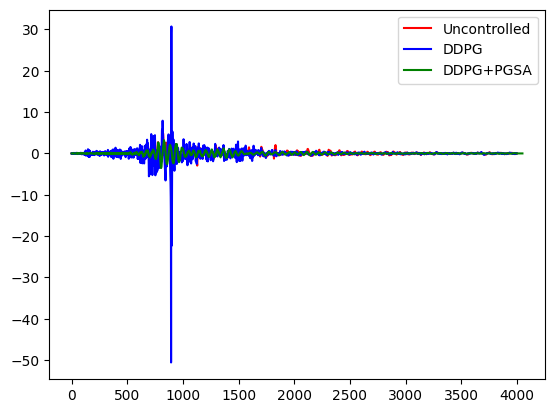

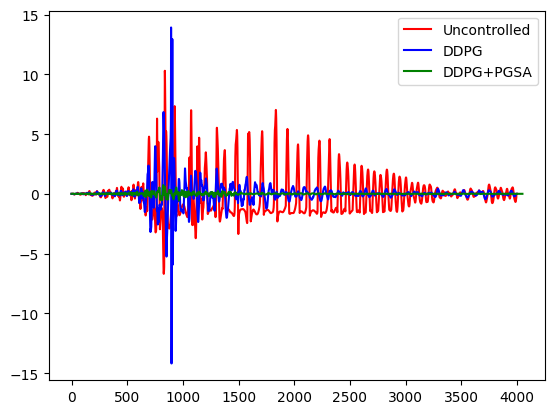

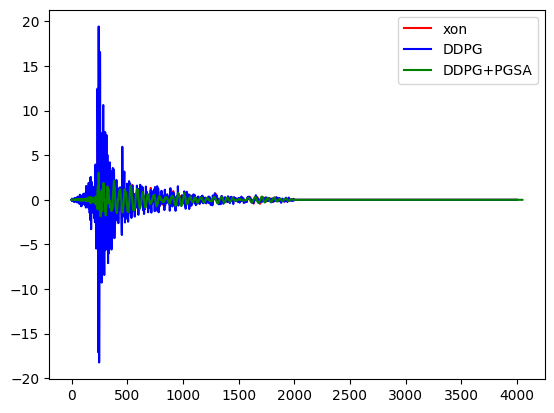

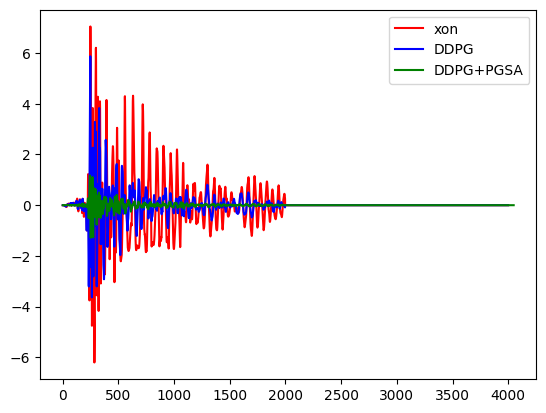

In [189]:
#  Control force
plt.figure()
plt.plot(yon[:,0, 4],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(ypn[:,0, 4],'b',label='DDPG')
plt.plot(yp[:,0, 7],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(yon[:,7, 4],'r',label='Uncontrolled')
#plt.plot(env.amplitude,label="path")
plt.plot(ypn[:,7, 4],'b',label='DDPG')
plt.plot(yp[:,7, 7],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(yon[:,0, 7],'r',label='xon')
#plt.plot(env.amplitude,label="path")
plt.plot(ypn[:,0, 7],'b',label='DDPG')
plt.plot(yp[:,0, 11],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(yon[:,7, 7],'r',label='xon')
#plt.plot(env.amplitude,label="path")
plt.plot(ypn[:,7, 7],'b',label='DDPG')
plt.plot(yp[:,7, 11],'g',label='DDPG+PGSA')
plt.legend()


In [ ]:
#  Control force
plt.figure()
plt.plot(U[:,0, 15],'r',label='PGSA')
#plt.plot(env.amplitude,label="path")
plt.plot(Action1[:,0, 15],'b',label='DDPG')
plt.legend()

plt.figure()
plt.plot(U[:,1, 15],'r',label='PGSA')
#plt.plot(env.amplitude,label="path")
plt.plot(Action1[:,1, 15],'b',label='DDPG')
plt.legend()

plt.figure()
plt.plot(U[:,2, 15],'r',label='PGSA')
#plt.plot(env.amplitude,label="path")
plt.plot(Action1[:,2, 15],'b',label='DDPG')
plt.legend()


In [131]:
xon[:,0, 4].shape

(4000,)

In [132]:
input = np.array([t, xon[:,7, 4], xpn[:,7, 4], xon[:,7, 7], xpn[:,7, 7], yon[:,7, 4], ypn[:,7, 4], yon[:,7, 7], ypn[:,7, 7]])
print(input.T.shape)
result=np.savetxt('Response_NonLinear.txt', input.T, delimiter=' ')
print(result)

(4000, 9)
None


In [190]:
GMdt

array([0.02 , 0.02 , 0.01 , 0.01 , 0.01 , 0.01 , 0.02 , 0.02 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.005, 0.005, 0.02 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.01 , 0.01 , 0.005, 0.005, 0.02 ,
       0.02 , 0.02 , 0.02 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.01 , 0.01 , 0.01 , 0.01 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 ])